# BARB API Demo: A broadcaster case study


## The brief

The BBC would like to see how its regular daily news slots have performed over the last couple of years. In particular they would like to pick out any important trends and events over a timeseries of audience figures. 

## The API documentation

Our first step is to examine the API documentation which can be found [here](https://barb-api.co.uk/api-docs). Specificially we will be interested in the [programme_ratings](https://barb-api.co.uk/api-docs#tag/Events/operation/listProgrammeRatings) endpoint and the [panel](https://barb-api.co.uk/api-docs#tag/Metadata/operation/panelsList) and [stations](https://barb-api.co.uk/api-docs#tag/Metadata/operation/stationsList) metadata end points.

We might also look at the [Getting Started](https://barb-api.co.uk/api-docs#section/Getting-started) section for information about authentication and basic API usage.

## Set up the python environment

Next we set up our notebook with all the libraries we will need to access the API and analyse the data.

In [1]:
import requests
import numpy as np
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import time
pio.renderers.default = "jupyterlab"

## Get the access token

Following the steps in the Getting Started guide we run some python code to get an access token. This code uses your account details to get an access token from the API. Your creds.json file should include the email and password supplied by BARB. For example:

```
{"email": "me@coppelia.io", "password": "INSERT PASSWORD"}
```

In [8]:
with open("creds.json") as file:
    creds = json.loads(file.read())
api_root = "https://barb-api.co.uk/api/v1/"
token_request_url = api_root + "auth/token/"
response = requests.post(token_request_url, data = creds)
access_token = json.loads(response.text)['access']
headers = {'Authorization': 'Bearer {}'.format(access_token)}

## Get data from the API

### The panel code

Finally, we are only interested in the BBC Network panel so we can use the [panels](https://barb-api.co.uk/api-docs#tag/Metadata/operation/panelsList) end point to get the right code.

In [9]:
api_url = api_root + "panels/"
response = requests.get(url = api_url,headers=headers)
panels = response.json()
[p for p in panels if "bbc network" in p['panel_region'].lower()]

[{'panel_code': 50, 'panel_region': 'BBC Network', 'is_macro_region': False}]

### The station code

Next we need to use [the stations endpoint](https://barb-api.co.uk/api-docs#tag/Metadata/operation/stationsList) to get the station code for BBC 1

In [10]:
api_url = api_root + "stations/"
response = requests.get(url = api_url,headers=headers)
stations = response.json()
[s for s in stations if "bbc1" in s['station_name'].lower()]

[{'station_code': 10, 'station_name': 'BBC1'},
 {'station_code': 11, 'station_name': 'BBC1 Network'}]

### Querying the programme ratings endpoint

Now we know all the relevant metadata we can query the programme ratings endpoint. 

In [11]:
# A function to reshape the data in the way that we want it

def json_to_table(api_data):
    
    print("Downloading and processing {} programme events".format(len(api_data["events"])))
    
    # Loop through the events and then the audiences within the events
    programme_data = []
    for e in api_data['events']:
        prog_name = e['programme_content']['content_name'] if 'programme_content' == "None" else e['transmission_log_programme_name'].title()
        for v in e['audience_views']:
            programme_data.append({'panel_region': e['panel']['panel_region'],
                          'station_name': e['station']['station_name'],
                          'programme_name': prog_name,
                          'programme_start_datetime': e['programme_start_datetime']['standard_datetime'],
                          'audience_code': v['audience_code'],
                          'audience_size_hundreds': v['audience_size_hundreds']})
    # Convert the result into a data frame
    programme_data = pd.DataFrame(programme_data)

    # Format the transmission_time_period as a pandas datetime
    programme_data['programme_start_datetime'] = pd.to_datetime(programme_data['programme_start_datetime'])
    
    ## Add the audience category names. We have a temporary problem with duplicates in this data set hence the dropping of duplicates.
    audience_categories_df = pd.DataFrame(api_data['audience_categories']).drop_duplicates(subset=['audience_code'])
    programme_data = programme_data.merge(audience_categories_df, how = "left", on = "audience_code").drop("audience_code", axis=1)
    
    return programme_data

Note that we are using the `x_next_url` to download the data in chunks.

In [12]:
api_url = api_root + "programme_ratings/"

# The query parameters
params = {"min_transmission_date": "2020-01-01","max_transmission_date":"2022-12-31", 
          "station_code": 10, 
          "panel_code": 50,
         "consolidated": True, "limit": 5000}

# Query the API and turn the response into json
start_time = time.time()
r = requests.get(url=api_url, params=params, headers=headers)
api_data = r.json()
programme_data = json_to_table(api_data)
while r.headers.__contains__("X-Next"):
    x_next_url = r.headers["X-Next"]
    r = requests.get(url=x_next_url, headers=headers)
    data_increment = r.json()
    programme_data = pd.concat([programme_data, json_to_table(data_increment)])
print("The download took {:.0f} seconds ".format(time.time() - start_time))

The download took 267 seconds 


In [13]:
programme_data.shape

(4584640, 7)

This gives us the following table of data:

In [14]:
programme_data.tail(10)

,panel_region,station_name,programme_name,programme_start_datetime,audience_size_hundreds,audience_name,audience_target_size_hundreds
95177,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,216,Children 04-09,47690
95178,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,133,Children 04-06,23770
95179,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,43,Children 10-12,24840
95180,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,188,Boys 04-15,49550
95181,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,155,Boys 04-09,24740
95182,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,13,Boys 10-12,12700
95183,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,547,"Adults, Lightest Third",171460
95184,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,216,"Adults, Lightest Sixth",85720
95185,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,136,"ABC1 Adults, Lightest Third",98390
95186,BBC Network,BBC1,Bbc News,2022-09-18 00:09:25,108,"Adults 16-34, Lightest Third",47250


## Filtering for the news programmes

We can search the programme_names to get the ones we are looking for.

In [15]:
programme_data['programme_name'][programme_data['programme_name'].str.contains('News')].unique()

array(['Newsline', 'Bbc London News', 'News 24', 'Bbc News',
       "One O'Clock News", "Ten O'Clock News", "Six O'Clock News",
       'Newscast', 'Bbc News Special', 'Coronavirus: Bbc News Special',
       'Bbc Scotland News Special', 'Have I Got News For You',
       'The Coronavirus Newscast', 'Have I Got A Bit More News For You',
       'The Peoples News: Virus Diaries',
       'Bbc News Special: Pm Commons Statement', "The People'S News",
       'Coronavirus Update: Bbc News Special',
       'Bbc News Special: Coronavirus Update',
       'Have I Got 2020 News For You',
       'Have I Got A Bit More 2020 News For You',
       'Have I Got 2019 News For You',
       'Bbc Scotland News Special - Coronavirus', 'Bbc News At Six',
       'Bbc Newsline', 'Bbc News At Ten', 'Bbc News At One',
       'Joins Bbc News', 'Bbc News And Weather',
       'Leaving The Eu: Bbc News Special', 'Have I Got 2021 News For You',
       'Have I Got A Bit More 2021 News For You',
       "Bbc News Special: 

Now we filter for just the regular news programmes.

In [18]:
bbc_news = programme_data[programme_data['programme_name'].isin(["One O'Clock News", "Ten O'Clock News", "Six O'Clock News",
                                                                'Bbc News At One', 'Bbc News At Ten', 'Bbc News At Six'])]
bbc_news_all_homes = bbc_news[bbc_news['audience_name']=="All Homes"].sort_values(["programme_name", "programme_start_datetime"])


## Plotting the data

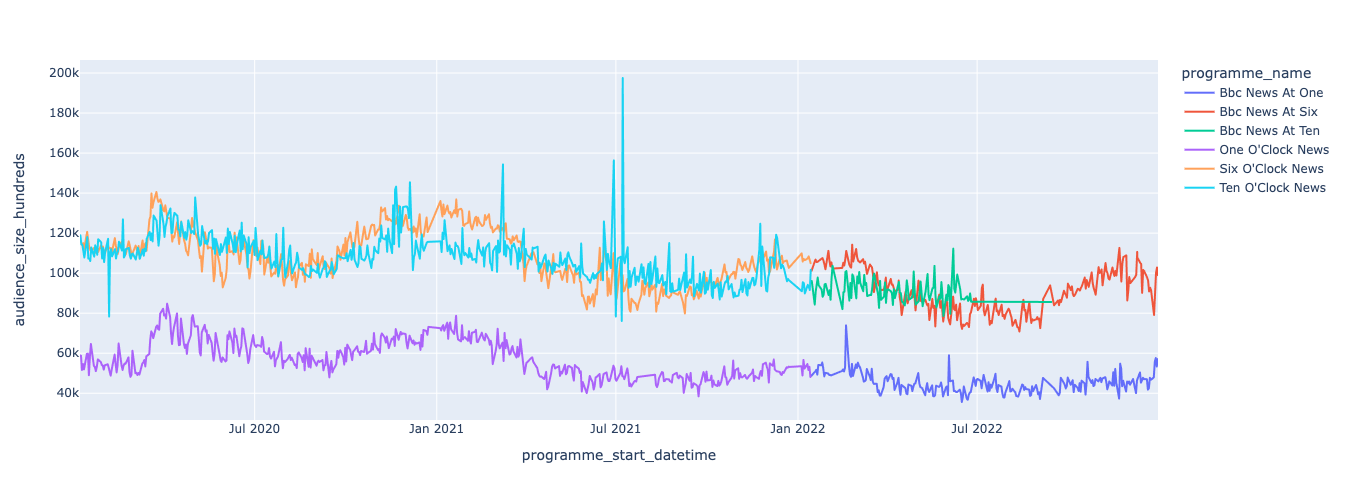

In [19]:
px.line(bbc_news_all_homes, x="programme_start_datetime", y="audience_size_hundreds", color="programme_name", width = 1300, height=500)

And adult audience penetration by audience. 

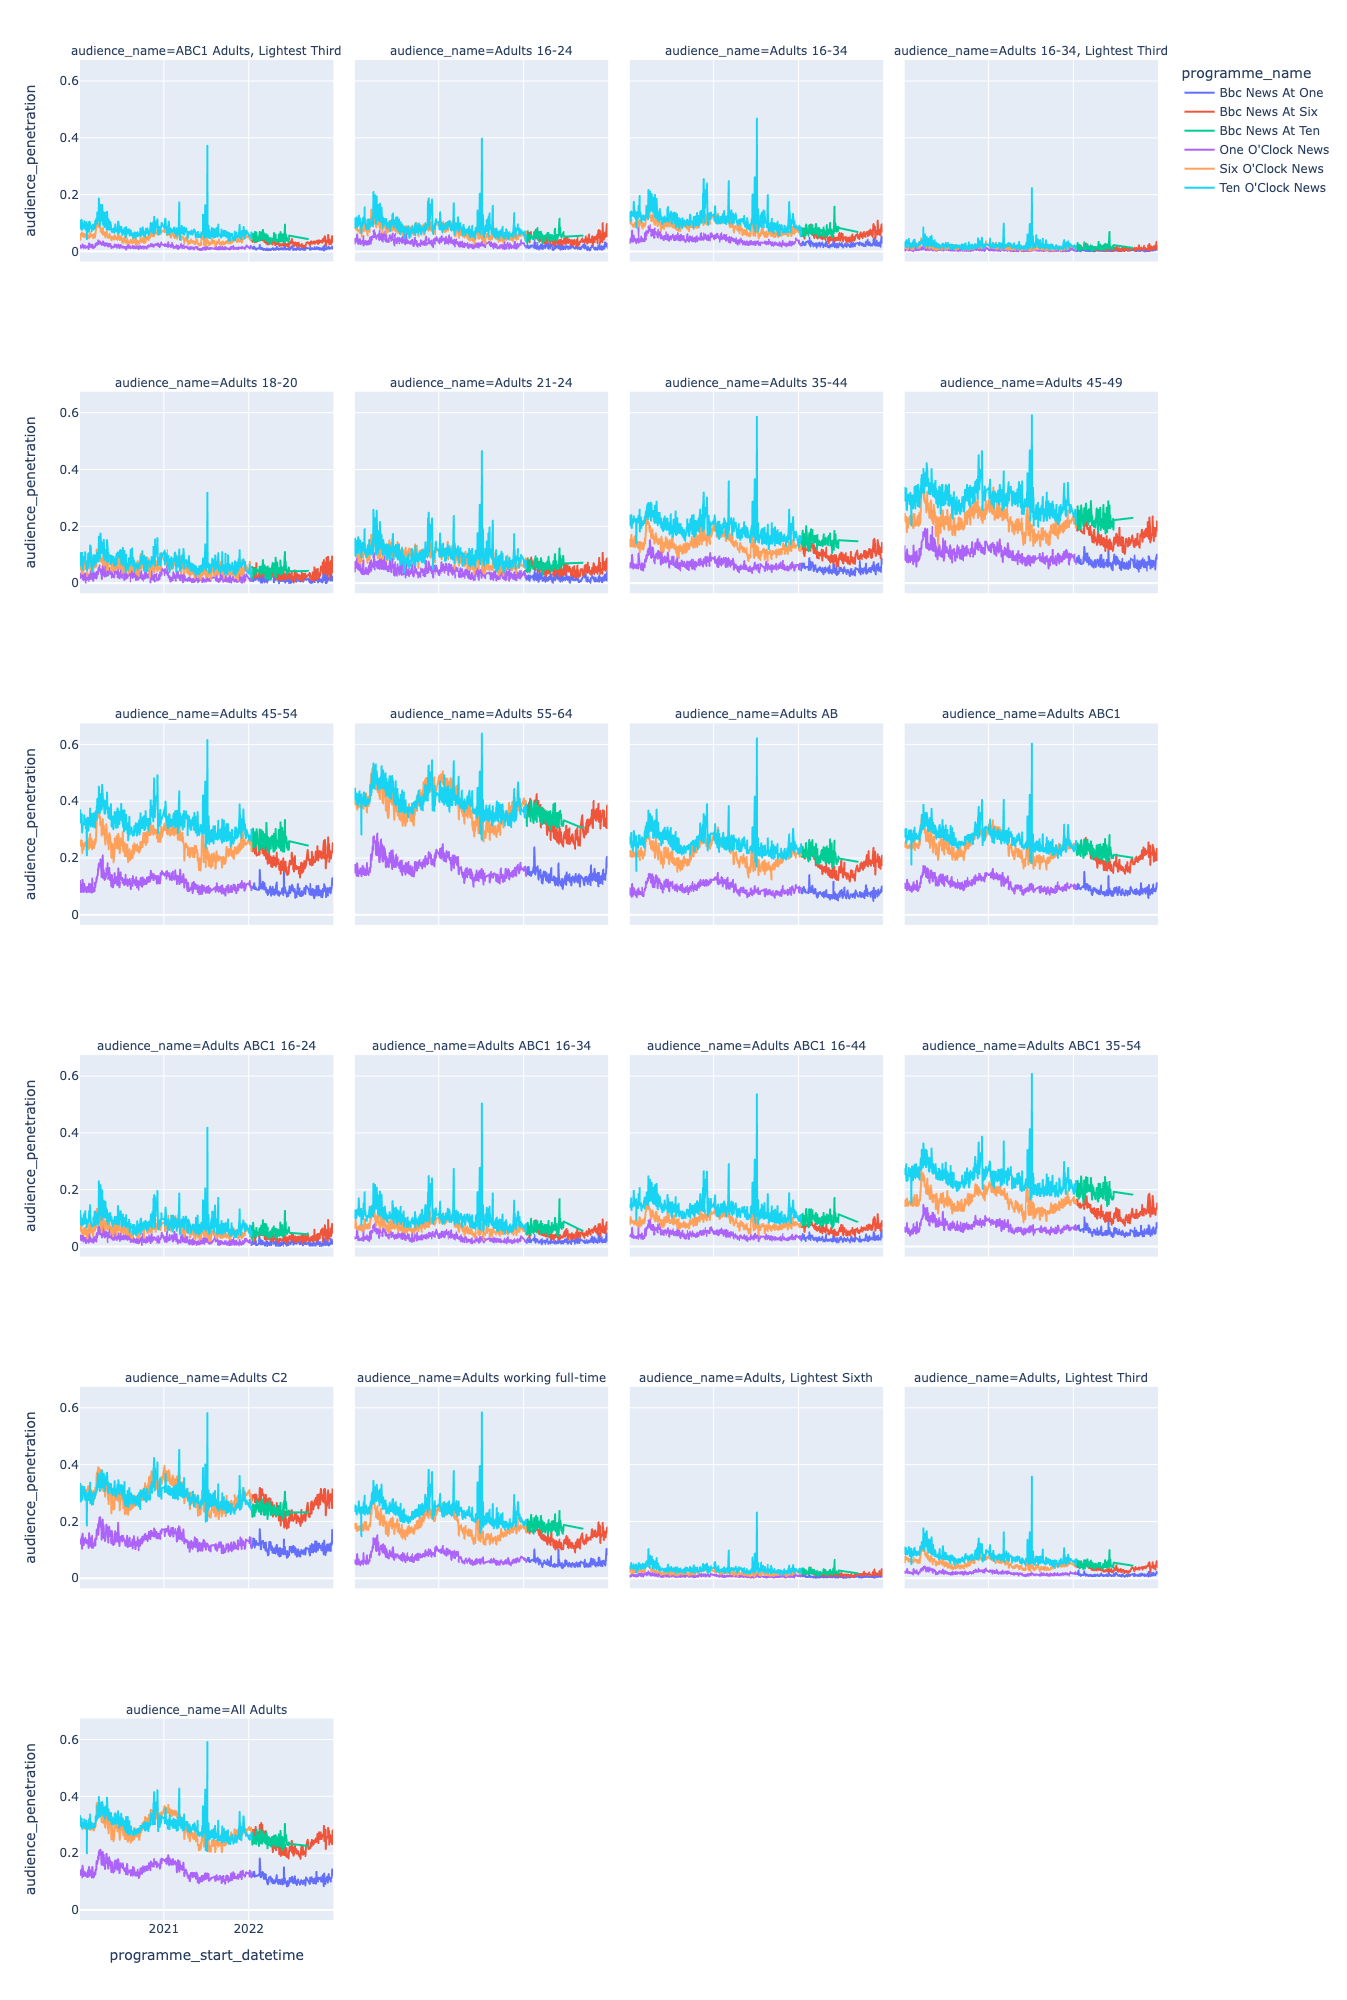

In [ ]:
bbc_news=bbc_news.assign(audience_penetration = bbc_news['audience_size_hundreds']/bbc_news['audience_target_size_hundreds'])
bbc_news = bbc_news.sort_values(["audience_name", "programme_name", "programme_start_datetime"])
px.line(bbc_news[bbc_news['audience_name'].str.contains("Adults")], 
        x="programme_start_datetime", y="audience_penetration", color="programme_name", 
        facet_col = "audience_name", facet_col_wrap=4, height=2000)